# Brain Tumor Detection with VGG16 Transfer Learning

This Jupyter Notebook demonstrates building a brain tumor detection model using the VGG16 pre-trained convolutional neural network (CNN) for transfer learning. Transfer learning leverages the knowledge learned by VGG16 on a massive image dataset (ImageNet) to accelerate your brain tumor detection model's training and potentially improve its performance.

**Steps:**

1. **Import Necessary Libraries**
2. **Load and Preprocess Brain Tumor Dataset**
   - Download and prepare the brain tumor dataset
   - Explore the dataset's content and structure (number of images, classes, etc.)
   - Preprocess images: resizing, normalization, data augmentation (optional)
3. **Prepare Dataloader**
4. **Load the VGG16 Model**
   - Use the deep learning library FAST.AI to load the VGG16 model pre-trained on ImageNet.
   - Freeze the convolutional base layers of VGG16 to retain their learned features.
   - Add custom classification layers suitable for brain tumor detection.
5. **Compile and Train the Model**
  - Define loss function (e.g., binary cross-entropy for binary classification)
   - Choose an optimizer (e.g., Adam)
   - Specify metrics (e.g., accuracy)
   - Train the model on the preprocessed brain tumor dataset
   - Monitor training progress (loss, accuracy) using visualization tools
   - Consider using techniques like early stopping or learning rate scheduling to optimize training
6. **Evaluate the Model**
   - Evaluate the model's performance on a separate test dataset that wasn't used for training.
   - Calculate metrics like accuracy, precision, recall, F1-score, and confusion matrix.
7. **Visualize Results**
   - Visualize intermediate activations using techniques like Grad-CAM to understand which image regions the model focuses on for classification.
   - Generate predictions on new brain tumor images.

**Additional Considerations:**

- Experiment with hyperparameter tuning (e.g., learning rate, batch size) to improve model performance.
- Consider using data augmentation techniques (e.g., random rotations, flips) to artificially increase the dataset size and improve model generalization.


This project can contribute to the advancement of medical image analysis and potentially aid in early diagnosis of brain tumors.


# 1. Import Necessary Libraries

In [1]:
! pip install --upgrade -q kaggle

In [2]:
pip install --upgrade -q fastai

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
import os

from fastai.vision.all import *
from fastai.imports import *

import ipywidgets
from ipywidgets import widget
import shutil
import warnings

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [5]:
warnings.filterwarnings('ignore')

# 2. Load and Preprocess Brain Tumor Dataset



*   The code utilizes !kaggle datasets download to download the "brain-tumor-detection-mri" dataset from Kaggle.

*   It then extracts the downloaded zip file using !unzip.
*   The code creates directories for the training and testing data within the Colab environment.
*   It further separates images into "no" and "yes" tumor categories within the training directory.
*   DataFrames are created to represent the training and test data, containing image paths and corresponding labels ("no" or "yes").

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"moaz47","key":"d4da9a1e0b1fe59c134d985a45a136a6"}'}

In [7]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d abhranta/brain-tumor-detection-mri

Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
brain-tumor-detection-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
! mkdir brain_tumor

! unzip /content/brain-tumor-detection-mri.zip -d brain_tumor

mkdir: cannot create directory ‘brain_tumor’: File exists
Archive:  /content/brain-tumor-detection-mri.zip
  inflating: brain_tumor/Brain_Tumor_Detection/no/No12.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No13.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No14.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No15.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No17.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No18.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No19.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no0.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no10.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no100.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1000.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1001.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1002.jpg  
  inflating: brain_tumor/Brain_Tum

In [10]:
_train = '/content/brain_tumor/Brain_Tumor_Detection'
_test = '/content/brain_tumor/Brain_Tumor_Detection/pred'

path_train = Path(_train)
path_test = Path(_test)

In [11]:
print(len(os.listdir(path_train)))
print(len(os.listdir(path_test)))

3
60


In [12]:
print(len(os.listdir(_train+'/no')))
print(len(os.listdir(_train+'/yes')))
print(len(os.listdir(_test)))

1500
1500
60


In [13]:
_no = os.listdir(_train+'/no')
_yes = os.listdir(_train+'/yes')
_pred = os.listdir(_test)

In [14]:
df1 = pd.DataFrame({'name': _no, 'type': 'no'})
df1['name'] = df1['name'].apply(lambda x: str(_train) + '/no/'+ x)

df2 = pd.DataFrame({'name': _yes, 'type': 'yes'})
df2['name'] = df2['name'].apply(lambda x: str(_train) + '/yes/'+ x)

train = pd.concat([df1, df2])
train.head()

,name,type
0,/content/brain_tumor/Brain_Tumor_Detection/no/no155.jpg,no
1,/content/brain_tumor/Brain_Tumor_Detection/no/no854.jpg,no
2,/content/brain_tumor/Brain_Tumor_Detection/no/no544.jpg,no
3,/content/brain_tumor/Brain_Tumor_Detection/no/no342.jpg,no
4,/content/brain_tumor/Brain_Tumor_Detection/no/no821.jpg,no


In [15]:
test = pd.DataFrame(_pred, columns=['name'])
test['name'] = test['name'].apply(lambda x: str(_test) + '/' + x)
test.head()

,name
0,/content/brain_tumor/Brain_Tumor_Detection/pred/pred18.jpg
1,/content/brain_tumor/Brain_Tumor_Detection/pred/pred10.jpg
2,/content/brain_tumor/Brain_Tumor_Detection/pred/pred29.jpg
3,/content/brain_tumor/Brain_Tumor_Detection/pred/pred44.jpg
4,/content/brain_tumor/Brain_Tumor_Detection/pred/pred14.jpg


## Copy files from source to destination



*   The script utilizes shutil.move to split the training data into separate folders for "no" and "yes" categories within the "train" directory.

*   Similarly, test images are moved to the "test" directory.



In [16]:
!mkdir train
!mkdir test

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists


In [17]:
os.chdir('/content/train')

In [18]:
os.listdir(path_train)

['pred', 'yes', 'no']

In [19]:
list_type = os.listdir(path_train)
list_type.remove('pred')
list_type

['yes', 'no']

In [20]:
for i in list_type:
  os.mkdir(i)

FileExistsError: [Errno 17] File exists: 'yes'

In [21]:
destination = '/content/train'
count = 0
for i in list_type:
  li = []
  new_df = train[train['type']==i]
  li = new_df['name'].tolist()
  for j in li:
    shutil.move(j, destination+'/'+i)
    count = count + 1
  print(count)

Error: Destination path '/content/train/yes/y1277.jpg' already exists

In [22]:
os.chdir('/content/test')

In [23]:
destination = '/content/test'
count = 0
li = []
li = test['name'].tolist()
for j in li:
  shutil.move(j, destination)
  count = count + 1
print(count)

Error: Destination path '/content/test/pred18.jpg' already exists

In [24]:
os.chdir('/content')

## Modifying train and test dataframes



*   The code adjusts image paths within the DataFrames to reflect their new locations after moving. This ensures the model can access images correctly.



In [24]:
train['name'] = train['name'].apply(lambda x: x.replace(_train + '/yes', "/content/train/yes"))
train['name'] = train['name'].apply(lambda x: x.replace(_train + '/no', "/content/train/no"))
train['type'] = train['type'].apply(lambda x: 1 if x == 'yes' else 0)
train.head()

,name,type
0,/content/train/no/no155.jpg,0
1,/content/train/no/no854.jpg,0
2,/content/train/no/no544.jpg,0
3,/content/train/no/no342.jpg,0
4,/content/train/no/no821.jpg,0


In [25]:
test['name'] = test['name'].apply(lambda x: x.replace(_test, "/content/test"))
test.head()

,name
0,/content/test/pred18.jpg
1,/content/test/pred10.jpg
2,/content/test/pred29.jpg
3,/content/test/pred44.jpg
4,/content/test/pred14.jpg


# 3. Prepare Dataloader

In [26]:
def get_x(r): return r['name']
def get_y(r): return r['type']

size = 256
item_tfms = Resize(256)
batch_tfms = [*aug_transforms(size=size, min_scale=0.75, max_lighting=0.4, max_rotate = 15), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # splits the data into training (80%) and validation (20%) sets with a fixed random seed for reproducibility.
                   get_x= get_x, # functions extract image paths from the dataframes.
                   get_y= get_y, # functions extract labels from the dataframes.
                   item_tfms = item_tfms, # defines image transformations applied to each item (e.g., resizing to 256x256).
                   batch_tfms = batch_tfms # defines batch transformations applied to the dataset (e.g., data augmentation).
                   )

In [27]:
dls = dblock.dataloaders(train, seed=42, bs=8)         # train dataloader
test_dl = dls.test_dl(test, with_labels=True, seed=42) # test dataloader


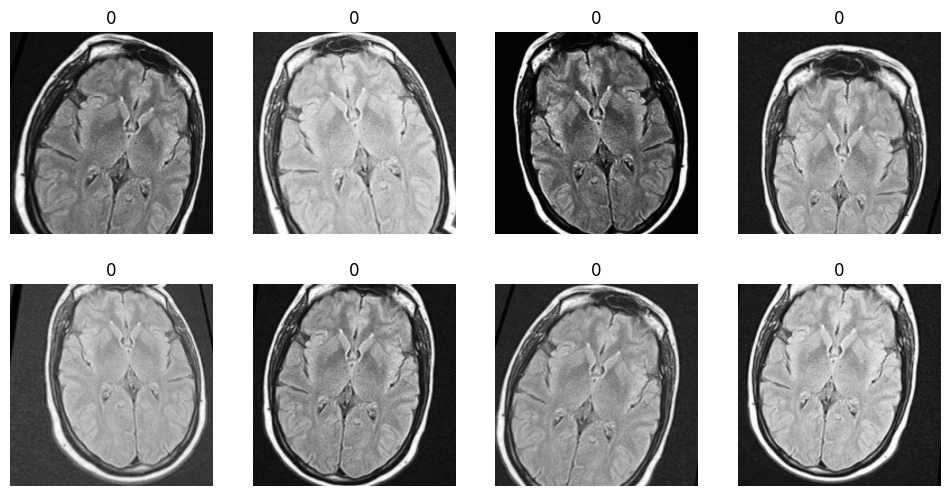

In [28]:
dls.show_batch(max_n=8, unique=True)

# 4. Load the Model

In [37]:
loss_func = LabelSmoothingCrossEntropy()
learn = vision_learner(dls, vgg16, loss_func = loss_func, metrics=[accuracy, Precision(), Recall(), F1Score()])

In [38]:
# Freeze all the layers
learn.freeze()

# Replace the head with a binary classifier (adjust the last layer)
learn.model[-1] = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(512, 2)  # Binary classification, so output 2 classes
)

# 5. Compile and Train the Model

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.705415,0.705419,0.501667,0.500000,0.143813,0.223377,00:31


SuggestedLRs(valley=0.43651583790779114)

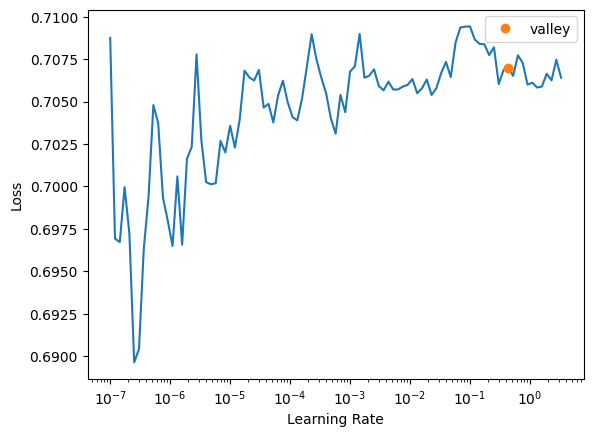

In [39]:
learn.fit_one_cycle(1)
learn.lr_find()

In [40]:
learn.fit_one_cycle(4, 0.4365158, wd=0.2)  # train the model with the chosen learning rate.

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.702548,0.705419,0.501667,0.500000,0.143813,0.223377,00:32
1,0.699031,0.705419,0.501667,0.500000,0.143813,0.223377,00:33
2,0.710045,0.705419,0.501667,0.500000,0.143813,0.223377,00:33
3,0.704057,0.705419,0.501667,0.500000,0.143813,0.223377,00:32


SuggestedLRs(valley=9.120108734350652e-05)

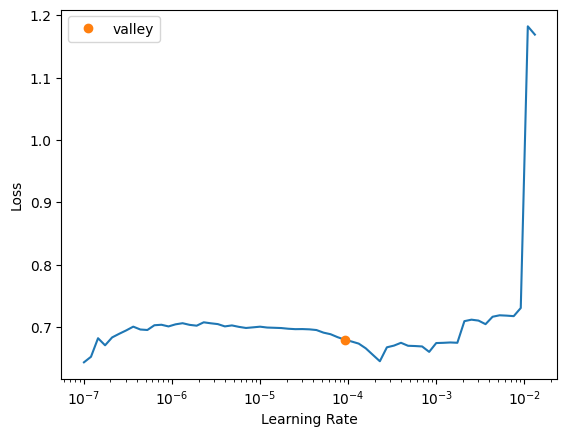

In [41]:
# Unfreeze and Fine-tune: Unfreeze the model and continue training to fine-tune the entire network.
learn.unfreeze()
learn.lr_find()

In [42]:
# continue training to fine-tune the entire network.
lr_ufrzn = slice(1e-5, 9e-5)
learn.fit_one_cycle(8, lr_ufrzn, wd=0.2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.565534,0.455462,0.840000,0.894942,0.769231,0.827338,01:07
1,0.329850,0.279037,0.965000,0.954248,0.976589,0.965289,01:07
2,0.281443,0.269977,0.970000,0.957655,0.983278,0.970297,01:08
3,0.252240,0.247329,0.986667,0.980198,0.993311,0.986711,01:07
4,0.239163,0.235762,0.988333,0.989933,0.986622,0.988275,01:08
5,0.229996,0.230690,0.993333,0.990033,0.996656,0.993333,01:08
6,0.224075,0.228420,0.993333,0.996633,0.989967,0.993289,01:09
7,0.224790,0.228363,0.996667,0.993355,1.000000,0.996667,01:11


In [43]:
learn.save('braintumorVGG16')
learn.load('braintumorVGG16')

# 6. Evaluate the Model

In [62]:
score = learn.validate(dl=dls.valid)
score

(#5) [0.22836314141750336,0.996666669845581,0.9933554817275747,1.0,0.9966666666666666]

Validation Loss: 0.22836314141750336

Accuracy: 0.996666669845581 (or 99.67%)

Precision: 0.9933554817275747 (or 99.34%)

Recall: 1.0 (or 100%)

F1 Score: 0.9966666666666666 (or 99.67%)

Interpretation
- **High Accuracy and F1 Score**: The model achieved very high accuracy (99.67%) and F1 score (99.67%) on the validation dataset, indicating that it performs well in correctly predicting both positive and negative instances.

- **Excellent Precision and Recall**: The model shows high precision (99.34%) and perfect recall (100%), suggesting that it makes very few mistakes in both false positives and false negatives.

- **Low Validation Loss**: The average validation loss (0.228) is relatively low, indicating that the model's predictions are close to the actual targets on average, which is a good sign of its effectiveness.

In [49]:
learn.export(fname='brain_tumorVGG16.pkl')

# 7. Results

In [77]:
_, targs, preds = learn.get_preds(dl=dls.valid, with_decoded=True) # retrieve predictions and target labels.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

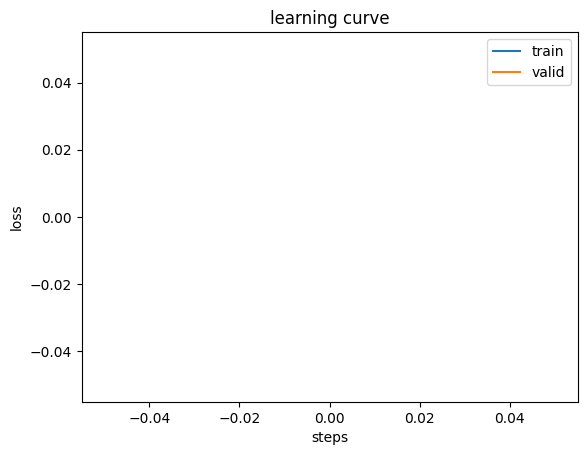

In [85]:
# Plot learning curve
learn.recorder.plot_loss()

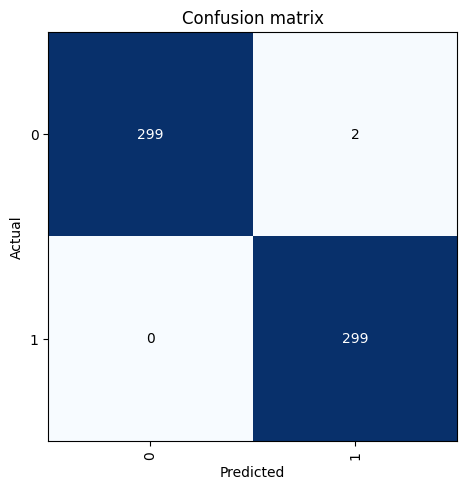

In [81]:
# Plot the confusion matrix to understand the distribution of predicted versus actual labels in a classification task.

interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)
interp.plot_confusion_matrix()

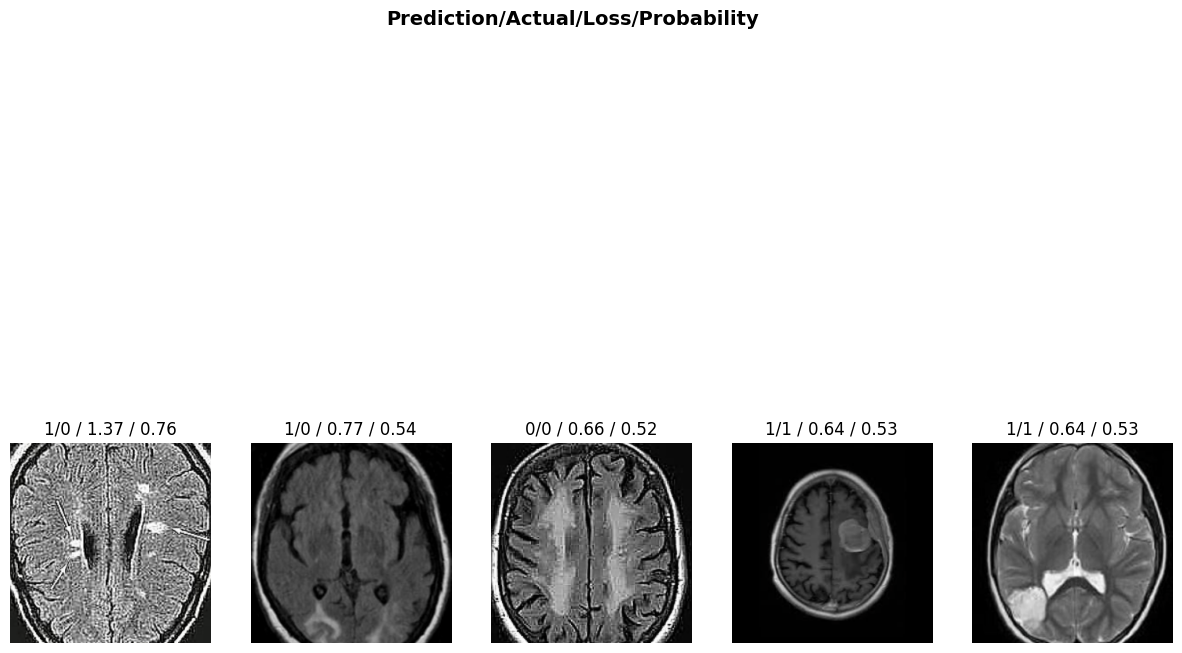

In [84]:
# Visualize the Grad-CAM (Gradient-weighted Class Activation Mapping)
interp.plot_top_losses(k=5, nrows=1, figsize=(15,11))